In [1]:
### check image resize cifar 10
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Torch Tutorial Cifar-10

#### Import functions

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [36]:
torch.set_default_device('cpu') 

In [37]:
device = torch.device('cuda:0')

#### Prepared DataSet

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root="./../data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./../data/", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Prepare Model

In [76]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.hash1 = nn.Linear(120, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net = Net( HASH_SIZE )
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (hash1): Linear(in_features=120, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

#### Train Parameters

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
iterations = 15

In [117]:
for epoch in range( iterations ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, hash_ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

1  101  201  301  401  501  601  701  [1] loss: 135.70412968471646 accurancy: 93 %
1  101  201  301  401  501  601  701  [2] loss: 135.75516540929675 accurancy: 93 %
1  101  201  301  401  501  601  701  [3] loss: 135.557621832937 accurancy: 93 %
1  101  201  301  401  501  601  701  [4] loss: 135.7344008386135 accurancy: 93 %
1  101  201  301  401  501  601  701  [5] loss: 135.62759321555495 accurancy: 93 %
1  101  201  301  401  501  601  701  [6] loss: 135.62428053840995 accurancy: 93 %
1  101  201  301  401  501  601  701  [7] loss: 135.58444859087467 accurancy: 93 %
1  101  201  301  401  501  601  701  [8] loss: 135.61104176566005 accurancy: 93 %
1  101  201  301  401  501  601  701  [9] loss: 135.62416483461857 accurancy: 93 %
1  101  201  301  401  501  601  701  [10] loss: 135.85613089613616 accurancy: 93 %
1  101  201  301  401  501  601  701  [11] loss: 135.7445394359529 accurancy: 93 %
1  101  201  301  401  501  601  701  [12] loss: 135.618285253644 accurancy: 93 %
1  101 

#### Save Model

In [123]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Load Model

In [124]:
net = Net( HASH_SIZE ).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Check visually

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

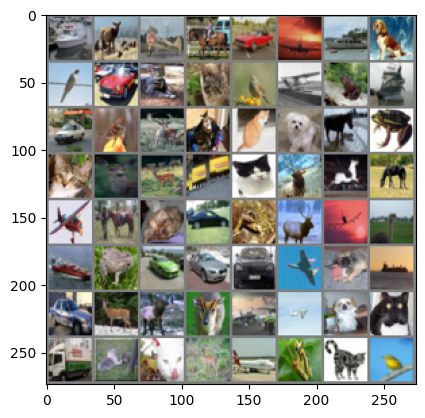

ship  deer  plane horse car   plane ship  dog   bird  car   cat   cat   bird  plane frog  ship  car   bird  deer  cat   cat   dog   horse frog  cat   deer  deer  truck cat   deer  horse horse plane horse dog   car   frog  deer  plane horse ship  frog  car   car   car   plane dog   ship  car   deer  deer  dog   cat   plane dog   cat   truck cat   cat   deer  plane frog  cat   bird 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1.], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [126]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

outputs, hashes = net(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(predicted.shape[0])))
print(torch.round(hashes)[0])

#### Check Accurancy on test set

In [127]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [128]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.8 %
Accuracy for class: car   is 73.0 %
Accuracy for class: bird  is 52.3 %
Accuracy for class: cat   is 41.0 %
Accuracy for class: deer  is 52.8 %
Accuracy for class: dog   is 49.4 %
Accuracy for class: frog  is 73.0 %
Accuracy for class: horse is 65.8 %
Accuracy for class: ship  is 72.8 %
Accuracy for class: truck is 65.7 %


### CustomDataSet ( ImageNet )

In [119]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [120]:
IMAGENET_PATH = "../data/Imagenet32_train/"

In [132]:
import os
import _pickle as cPickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

In [133]:
images2, labels2 = load_databatch(IMAGENET_PATH, 1)

In [138]:
print( type(images2) )
print( type(labels2) )

<class 'numpy.ndarray'>
<class 'list'>


In [153]:
images2 = images2.astype(np.float32).reshape(128116,3,32,32)

In [154]:
dataset = CustomDataset(torch.from_numpy(images2), torch.Tensor(labels2) )

In [155]:
ImageNetLoader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [156]:
correct = 0
total = 0

with torch.no_grad():
    for data in ImageNetLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %


### Concat two models

In [162]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [164]:
net_add = Net( HASH_SIZE ).to(device)

In [165]:
model2 = nn.Sequential(resnet50, net_add)

In [166]:
model2

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [167]:
# https://discuss.pytorch.org/t/add-layers-on-pretrained-model/88760
# https://stackoverflow.com/questions/53901603/how-to-transfer-weight-of-own-model-to-same-network-but-different-number-of-clas
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492
# https://github.com/flyingpot/pytorch_deephash/blob/master/net.py